# Export to onnx

# Export to onnx

In [6]:
import os
from glob import glob

os.chdir("./DAMO-YOLO")

def get_latest_checkpoint(base_dir="./workdirs/damoyolo_tinynasL18_Ns-GC10/"):
  
    ckpt_files = glob(os.path.join(base_dir, "*.pth"))
    if not ckpt_files:
        return None

    latest_ckpt = max(ckpt_files, key=os.path.getmtime)
    return latest_ckpt
latest_ckpt = get_latest_checkpoint()

In [2]:
# DAMO-YOLO ONNX Converter Notebook
# Based on the original converter.py script

# Import necessary libraries
import os

import onnx
import torch
from torch import nn
from loguru import logger

# Import required modules from DAMO-YOLO
from damo.base_models.core.end2end import End2End
from damo.base_models.core.ops import RepConv, SiLU
from damo.config.base import parse_config
from damo.detectors.detector import build_local_model
from damo.utils.model_utils import get_model_info, replace_module

# Define configuration parameters
# Modify these according to your needs
config_file = "configs/damoyolo_tinynasL18_Ns-GC10.py"
ckpt_path = latest_ckpt
batch_size = 1
img_height = 416
img_width = 416
opset_version = 11
device = "cuda"  #cpu or cuda

# Create an onnx filename based on the config file
onnx_name = config_file.split('/')[-1].replace('.py', '.onnx')

# Parse configuration file
config = parse_config(config_file)

# Update batch size in config
if batch_size is not None:
    config.test.batch_size = batch_size

# Build the model
model = build_local_model(config, device)
model.eval()

# Load checkpoint
ckpt = torch.load(ckpt_path, map_location=device)
if 'model' in ckpt:
    ckpt = ckpt['model']
model.load_state_dict(ckpt, strict=True)
print(f'Checkpoint loaded from {ckpt_path}')

# Replace SiLU with export-friendly version
model = replace_module(model, nn.SiLU, SiLU)

# Switch RepConv modules to deploy mode
for layer in model.modules():
    if isinstance(layer, RepConv):
        layer.switch_to_deploy()

# Print model information
info = get_model_info(model, (img_height, img_width))
print(f"Model info: {info}")

# Set model to not use NMS (we'll handle that separately if needed)
model.head.nms = False

# Create dummy input tensor for ONNX export
dummy_input = torch.randn(batch_size, 3, img_height, img_width).to(device)

# Run a forward pass to ensure everything works
_ = model(dummy_input)

# Export to ONNX
input_name = "images"  # Default input name
output_name = "output"  # Default output name

print(f"Exporting model to ONNX format: {onnx_name}")
torch.onnx.export(
    model,
    dummy_input,
    onnx_name,
    input_names=[input_name],
    output_names=[output_name],
    opset_version=opset_version,
)

# Load and simplify the ONNX model
onnx_model = onnx.load(onnx_name)

try:
    import onnxsim
    print('Starting to simplify ONNX model...')
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'Simplification check failed'
    print('ONNX model simplified successfully')
except Exception as e:
    print(f'ONNX simplification failed: {e}')

# Save the simplified model
onnx.save(onnx_model, onnx_name)
print(f'ONNX model saved to {onnx_name}')

# Verify the output exists
if os.path.exists(onnx_name):
    file_size = os.path.getsize(onnx_name) / (1024 * 1024)  # size in MB
    print(f"Successfully exported ONNX model: {onnx_name}")
    print(f"File size: {file_size:.2f} MB")
else:
    print("Export failed!")

Checkpoint loaded from ./workdirs/damoyolo_tinynasL18_Ns-GC10/latest_ckpt.pth
Model info: backbone's params(M): 0.88, flops(G): 1.21, latency(ms): 3.948
neck's params(M): 0.50, flops(G): 0.37, latency(ms): 3.527
head's params(M): 0.01, flops(G): 0.02, latency(ms): 0.923
total latency(ms): 7.633, total flops(G): 1.59, total params(M): 1.39

Exporting model to ONNX format: damoyolo_tinynasL18_Ns-GC10.onnx


/home/z890/Documents/DAMO_YOLO_AMD/DAMO-YOLO/damo/structures/image_list.py:47: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  image_sizes = [tensor.shape[-2:] for tensor in tensors]
/home/z890/Documents/DAMO_YOLO_AMD/DAMO-YOLO/damo/detectors/detector.py:58: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tea:
/home/z890/Documents/DAMO_YOLO_AMD/DAMO-YOLO/damo/base_models/heads/zero_head.py:251: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. T

ONNX simplification failed: No module named 'onnxsim'
ONNX model saved to damoyolo_tinynasL18_Ns-GC10.onnx
Successfully exported ONNX model: damoyolo_tinynasL18_Ns-GC10.onnx
File size: 5.37 MB


# Inference

The current example uses an .onnx model that was generated from our own training process.
If you'd like to replace it with a different pretrained model, you can visit this GitHub page and search for the keyword "AliYun Download" to find and download other available models.
https://github.com/tinyvision/DAMO-YOLO?tab=readme-ov-file <br>


In [1]:
import os
import random

#Randomly selects one image file from the valid dataset.
def get_one_val_image(base_dir="./datasets/GC10-Det/valid/img"):
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"Directory not found: {base_dir}")
    images = [f for f in os.listdir(base_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not images:
        raise FileNotFoundError("No image files found in the directory.")
    selected_image = random.choice(images)
    return os.path.join(base_dir, selected_image)

TEST_MEDIA_PATH = get_one_val_image()
print(TEST_MEDIA_PATH)

./datasets/GC10-Det/valid/img/img_08_425639900_00613.jpg


Inference with onnx engine!
Class: crescent_gap, Box: [1613.9, 465.8, 1910.5, 1000.1], Score: 0.70
Class: welding_line, Box: [1828.2, 749.2, 2065.9, 810.7], Score: 0.51


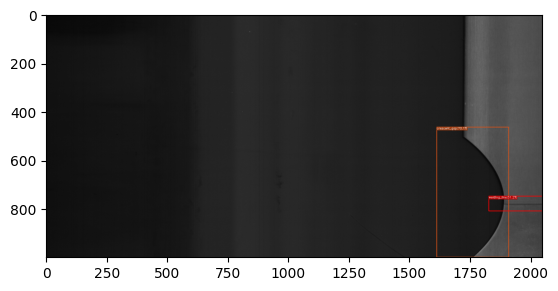

In [10]:
import argparse
import os

import cv2
import numpy as np
import torch
from loguru import logger
from PIL import Image

from damo.base_models.core.ops import RepConv
from damo.config.base import parse_config
from damo.detectors.detector import build_local_model
from damo.utils import get_model_info, postprocess
from damo.utils.demo_utils import transform_img
from damo.structures.image_list import ImageList
from damo.structures.bounding_box import BoxList
import matplotlib.pyplot as plt

IMAGES=['png', 'jpg']
VIDEOS=['mp4', 'avi']


class Infer():
    def __init__(self, config, infer_size=[640,640], device='cuda', output_dir='./', ckpt=None, end2end=False):

        self.ckpt_path = ckpt
        suffix = ckpt.split('.')[-1]
        if suffix == 'onnx':
            self.engine_type = 'onnx'
        elif suffix == 'trt':
            self.engine_type = 'tensorRT'
        elif suffix in ['pt', 'pth']:
            self.engine_type = 'torch'
        self.end2end = end2end # only work with tensorRT engine
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        if "class_names" in config.dataset:
            self.class_names = config.dataset.class_names
        else:
            self.class_names = []
            for i in range(config.model.head.num_classes):
                self.class_names.append(str(i))
            self.class_names = tuple(self.class_names)

        self.infer_size = infer_size
        config.dataset.size_divisibility = 0
        self.config = config
        self.model = self._build_engine(self.config, self.engine_type)

    def _pad_image(self, img, target_size):
        n, c, h, w = img.shape
        assert n == 1
        assert h<=target_size[0] and w<=target_size[1]
        target_size = [n, c, target_size[0], target_size[1]]
        pad_imgs = torch.zeros(*target_size)
        pad_imgs[:, :c, :h, :w].copy_(img)

        img_sizes = [img.shape[-2:]]
        pad_sizes = [pad_imgs.shape[-2:]]

        return ImageList(pad_imgs, img_sizes, pad_sizes)


    def _build_engine(self, config, engine_type):

        print(f'Inference with {engine_type} engine!')
        if engine_type == 'torch':
            model = build_local_model(config, self.device)
            ckpt = torch.load(self.ckpt_path, map_location=self.device)
            model.load_state_dict(ckpt['model'], strict=True)
            for layer in model.modules():
                if isinstance(layer, RepConv):
                    layer.switch_to_deploy()
            model.eval()
        elif engine_type == 'tensorRT':
            model = self.build_tensorRT_engine(self.ckpt_path)
        elif engine_type == 'onnx':
            model, self.input_name, self.infer_size, _, _ = self.build_onnx_engine(self.ckpt_path)
        else:
            NotImplementedError(f'{engine_type} is not supported yet! Please use one of [onnx, torch, tensorRT]')

        return model

    def build_tensorRT_engine(self, trt_path):

        import tensorrt as trt
        from cuda import cuda
        loggert = trt.Logger(trt.Logger.INFO)
        trt.init_libnvinfer_plugins(loggert, '')
        runtime = trt.Runtime(loggert)
        with open(trt_path, 'rb') as t:
            model = runtime.deserialize_cuda_engine(t.read())
            context = model.create_execution_context()

        allocations = []
        inputs = []
        outputs = []
        for i in range(context.engine.num_bindings):
            is_input = False
            if context.engine.binding_is_input(i):
                is_input = True
            name = context.engine.get_binding_name(i)
            dtype = context.engine.get_binding_dtype(i)
            shape = context.engine.get_binding_shape(i)
            if is_input:
                batch_size = shape[0]
            size = np.dtype(trt.nptype(dtype)).itemsize
            for s in shape:
                size *= s
            allocation = cuda.cuMemAlloc(size)
            binding = {
                'index': i,
                'name': name,
                'dtype': np.dtype(trt.nptype(dtype)),
                'shape': list(shape),
                'allocation': allocation,
                'size': size
            }
            allocations.append(allocation[1])
            if context.engine.binding_is_input(i):
                inputs.append(binding)
            else:
                outputs.append(binding)
        trt_out = []
        for output in outputs:
            trt_out.append(np.zeros(output['shape'], output['dtype']))

        def predict(batch):  # result gets copied into output
            # transfer input data to device
            cuda.cuMemcpyHtoD(inputs[0]['allocation'][1],
                          np.ascontiguousarray(batch), int(inputs[0]['size']))
            # execute model
            context.execute_v2(allocations)
            # transfer predictions back
            for o in range(len(trt_out)):
                cuda.cuMemcpyDtoH(trt_out[o], outputs[o]['allocation'][1],
                              outputs[o]['size'])
            return trt_out

        return predict

    def build_onnx_engine(self, onnx_path):

        import onnxruntime

        session = onnxruntime.InferenceSession(onnx_path)
        input_name = session.get_inputs()[0].name
        input_shape = session.get_inputs()[0].shape

        out_names = []
        out_shapes = []
        for idx in range(len(session.get_outputs())):
            out_names.append(session.get_outputs()[idx].name)
            out_shapes.append(session.get_outputs()[idx].shape)
        return session, input_name, input_shape[2:], out_names, out_shapes

    def preprocess(self, origin_img):

        img = transform_img(origin_img, 0,
                            **self.config.test.augment.transform,
                            infer_size=self.infer_size)
        # img is a image_list
        oh, ow, _  = origin_img.shape
        img = self._pad_image(img.tensors, self.infer_size)

        img = img.to(self.device)
        return img, (ow, oh)

    def postprocess(self, preds, image, origin_shape=None):

        if self.engine_type == 'torch':
            output = preds

        elif self.engine_type == 'onnx':
            scores = torch.Tensor(preds[0])
            bboxes = torch.Tensor(preds[1])
            output = postprocess(scores, bboxes,
                self.config.model.head.num_classes,
                self.config.model.head.nms_conf_thre,
                self.config.model.head.nms_iou_thre,
                image)
        elif self.engine_type == 'tensorRT':
            if self.end2end:
                nums = preds[0]
                boxes = preds[1]
                scores = preds[2]
                pred_classes = preds[3]
                batch_size = boxes.shape[0]
                output = [None for _ in range(batch_size)]
                for i in range(batch_size):
                    img_h, img_w = image.image_sizes[i]
                    boxlist = BoxList(torch.Tensor(boxes[i][:nums[i][0]]),
                              (img_w, img_h),
                              mode='xyxy')
                    boxlist.add_field(
                        'objectness',
                        torch.Tensor(np.ones_like(scores[i][:nums[i][0]])))
                    boxlist.add_field('scores', torch.Tensor(scores[i][:nums[i][0]]))
                    boxlist.add_field('labels',
                              torch.Tensor(pred_classes[i][:nums[i][0]] + 1))
                    output[i] = boxlist
            else:
                cls_scores = torch.Tensor(preds[0])
                bbox_preds = torch.Tensor(preds[1])
                output = postprocess(cls_scores, bbox_preds,
                             self.config.model.head.num_classes,
                             self.config.model.head.nms_conf_thre,
                             self.config.model.head.nms_iou_thre, image)

        output = output[0].resize(origin_shape)
        bboxes = output.bbox
        scores = output.get_field('scores')
        cls_inds = output.get_field('labels')

        if self.engine_type == 'torch':
            bboxes = bboxes.detach().cpu().numpy()
            scores = scores.detach().cpu().numpy()
            cls_inds = cls_inds.detach().cpu().numpy()

        return bboxes, scores, cls_inds


    def forward(self, origin_image):

        image, origin_shape = self.preprocess(origin_image)

        if self.engine_type == 'torch':
            output = self.model(image)

        elif self.engine_type == 'onnx':
            image_np = np.asarray(image.tensors.cpu())
            output = self.model.run(None, {self.input_name: image_np})

        elif self.engine_type == 'tensorRT':
            image_np = np.asarray(image.tensors.cpu()).astype(np.float32)
            output = self.model(image_np)

        bboxes, scores, cls_inds = self.postprocess(output, image, origin_shape=origin_shape)

        return bboxes, scores, cls_inds

def vis_vid(img, boxes, scores, cls_ids, class_names=None):
    _COLORS = np.array([
        0.000, 0.447, 0.741, 0.850, 0.325, 0.098, 0.929, 0.694, 0.125, 0.494,
        0.184, 0.556, 0.466, 0.674, 0.188, 0.301, 0.745, 0.933, 0.635, 0.078,
        0.184, 0.300, 0.300, 0.300, 0.600, 0.600, 0.600, 1.000, 0.000, 0.000,
        1.000, 0.500, 0.000, 0.749, 0.749, 0.000, 0.000, 1.000, 0.000, 0.000,
        0.000, 1.000, 0.667, 0.000, 1.000, 0.333, 0.333, 0.000, 0.333, 0.667,
        0.000, 0.333, 1.000, 0.000, 0.667, 0.333, 0.000, 0.667, 0.667, 0.000,
        0.667, 1.000, 0.000, 1.000, 0.333, 0.000, 1.000, 0.667, 0.000, 1.000,
        1.000, 0.000, 0.000, 0.333, 0.500, 0.000, 0.667, 0.500, 0.000, 1.000,
        0.500, 0.333, 0.000, 0.500, 0.333, 0.333, 0.500, 0.333, 0.667, 0.500,
        0.333, 1.000, 0.500, 0.667, 0.000, 0.500, 0.667, 0.333, 0.500, 0.667,
        0.667, 0.500, 0.667, 1.000, 0.500, 1.000, 0.000, 0.500, 1.000, 0.333,
        0.500, 1.000, 0.667, 0.500, 1.000, 1.000, 0.500, 0.000, 0.333, 1.000,
        0.000, 0.667, 1.000, 0.000, 1.000, 1.000, 0.333, 0.000, 1.000, 0.333,
        0.333, 1.000, 0.333, 0.667, 1.000, 0.333, 1.000, 1.000, 0.667, 0.000,
        1.000, 0.667, 0.333, 1.000, 0.667, 0.667, 1.000, 0.667, 1.000, 1.000,
        1.000, 0.000, 1.000, 1.000, 0.333, 1.000, 1.000, 0.667, 1.000, 0.333,
        0.000, 0.000, 0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000,
        0.000, 1.000, 0.000, 0.000, 0.000, 0.167, 0.000, 0.000, 0.333, 0.000,
        0.000, 0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000, 0.000,
        1.000, 0.000, 0.000, 0.000, 0.167, 0.000, 0.000, 0.333, 0.000, 0.000,
        0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000, 0.000, 1.000,
        0.000, 0.000, 0.000, 0.143, 0.143, 0.143, 0.286, 0.286, 0.286, 0.429,
        0.429, 0.429, 0.571, 0.571, 0.571, 0.714, 0.714, 0.714, 0.857, 0.857,
        0.857, 0.000, 0.447, 0.741, 0.314, 0.717, 0.741, 0.50, 0.5, 0
    ]).astype(np.float32).reshape(-1, 3)
    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])

        color = (_COLORS[cls_id] * 255).astype(np.uint8).tolist()
        text = '{}:{:.1f}%'.format(class_names[cls_id], score * 100)
        txt_color = (0, 0, 0) if np.mean(_COLORS[cls_id]) > 0.5 else (255, 255,
                                                                      255)
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        txt_bk_color = (_COLORS[cls_id] * 255 * 0.7).astype(np.uint8).tolist()
        cv2.rectangle(img, (x0, y0 + 1),
                      (x0 + txt_size[0] + 1, y0 + int(1.5 * txt_size[1])),
                      txt_bk_color, -1)
        cv2.putText(img,
                    text, (x0, y0 + txt_size[1]),
                    font,
                    0.4,
                    txt_color,
                    thickness=1)

    return img

def vis_img(origin_img, bboxes, scores, cls_inds, infer_size, class_names=None):
    _COLORS = np.array([
        0.000, 0.447, 0.741, 0.850, 0.325, 0.098, 0.929, 0.694, 0.125, 0.494,
        0.184, 0.556, 0.466, 0.674, 0.188, 0.301, 0.745, 0.933, 0.635, 0.078,
        0.184, 0.300, 0.300, 0.300, 0.600, 0.600, 0.600, 1.000, 0.000, 0.000,
        1.000, 0.500, 0.000, 0.749, 0.749, 0.000, 0.000, 1.000, 0.000, 0.000,
        0.000, 1.000, 0.667, 0.000, 1.000, 0.333, 0.333, 0.000, 0.333, 0.667,
        0.000, 0.333, 1.000, 0.000, 0.667, 0.333, 0.000, 0.667, 0.667, 0.000,
        0.667, 1.000, 0.000, 1.000, 0.333, 0.000, 1.000, 0.667, 0.000, 1.000,
        1.000, 0.000, 0.000, 0.333, 0.500, 0.000, 0.667, 0.500, 0.000, 1.000,
        0.500, 0.333, 0.000, 0.500, 0.333, 0.333, 0.500, 0.333, 0.667, 0.500,
        0.333, 1.000, 0.500, 0.667, 0.000, 0.500, 0.667, 0.333, 0.500, 0.667,
        0.667, 0.500, 0.667, 1.000, 0.500, 1.000, 0.000, 0.500, 1.000, 0.333,
        0.500, 1.000, 0.667, 0.500, 1.000, 1.000, 0.500, 0.000, 0.333, 1.000,
        0.000, 0.667, 1.000, 0.000, 1.000, 1.000, 0.333, 0.000, 1.000, 0.333,
        0.333, 1.000, 0.333, 0.667, 1.000, 0.333, 1.000, 1.000, 0.667, 0.000,
        1.000, 0.667, 0.333, 1.000, 0.667, 0.667, 1.000, 0.667, 1.000, 1.000,
        1.000, 0.000, 1.000, 1.000, 0.333, 1.000, 1.000, 0.667, 1.000, 0.333,
        0.000, 0.000, 0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000,
        0.000, 1.000, 0.000, 0.000, 0.000, 0.167, 0.000, 0.000, 0.333, 0.000,
        0.000, 0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000, 0.000,
        1.000, 0.000, 0.000, 0.000, 0.167, 0.000, 0.000, 0.333, 0.000, 0.000,
        0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000, 0.000, 1.000,
        0.000, 0.000, 0.000, 0.143, 0.143, 0.143, 0.286, 0.286, 0.286, 0.429,
        0.429, 0.429, 0.571, 0.571, 0.571, 0.714, 0.714, 0.714, 0.857, 0.857,
        0.857, 0.000, 0.447, 0.741, 0.314, 0.717, 0.741, 0.50, 0.5, 0
    ]).astype(np.float32).reshape(-1, 3)

    img = origin_img.copy()
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(cls_inds[i])
        score = scores[i]

        x0, y0, x1, y1 = map(int, box)
        color = (_COLORS[cls_id] * 255).astype(np.uint8).tolist()
        text = f"{class_names[cls_id]}:{score * 100:.1f}%"

        txt_color = (0, 0, 0) if np.mean(_COLORS[cls_id]) > 0.5 else (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
        txt_bk_color = (_COLORS[cls_id] * 255 * 0.7).astype(np.uint8).tolist()

        # Draw box and label background
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)
        cv2.rectangle(img, (x0, y0 + 1),
                      (x0 + txt_size[0] + 1, y0 + int(1.5 * txt_size[1])),
                      txt_bk_color, -1)

        # Draw text
        cv2.putText(img, text, (x0, y0 + txt_size[1]),
                    font, 0.4, txt_color, thickness=1)

    return img

def make_parser():
    parser = argparse.ArgumentParser('DAMO-YOLO Demo')

    parser.add_argument('input_type',
                        default='image',
                        help="input type, support [image, video, camera]")
    parser.add_argument('-f',
                        '--config_file',
                        default=None,
                        type=str,
                        help='pls input your config file',)
    parser.add_argument('-p',
                        '--path',
                        default='./assets/dog.jpg',
                        type=str,
                        help='path to image or video')
    parser.add_argument('--camid',
                        type=int,
                        default=0,
                        help='camera id, necessary when input_type is camera')
    parser.add_argument('--engine',
                        default=None,
                        type=str,
                        help='engine for inference')
    parser.add_argument('--device',
                        default='cuda',
                        type=str,
                        help='device used to inference')
    parser.add_argument('--output_dir',
                        default='./demo',
                        type=str,
                        help='where to save inference results')
    parser.add_argument('--conf',
                        default=0.6,
                        type=float,
                        help='conf of visualization')
    parser.add_argument('--infer_size',
                        nargs='+',
                        type=int,
                        help='test img size')
    parser.add_argument('--end2end',
                        action='store_true',
                        help='trt engine with nms')
    parser.add_argument('--save_result',
                        default=False,
                        type=bool,
                        help='whether save visualization results')
    return parser

@logger.catch
def main():
    args = make_parser().parse_args([
    "image",  # image or video
    "-f", "./configs/damoyolo_tinynasL18_Ns-GC10.py",  # location of model configs 
    "--engine", "damoyolo_tinynasL18_Ns-GC10.onnx", # location of downloaded model weights, can be pth, onnx or trt
    "--conf", "0.5",  # confidence threshold
    "--infer_size", "416", "416", # inference image height and width
    "--device", "cuda",  # device cuda/cpu
    "--path", TEST_MEDIA_PATH,  
    #"--save_result", "True" # activate if you want to save
    ])
    config = parse_config(args.config_file)
    input_type = args.input_type

    infer_engine = Infer(config, infer_size=args.infer_size, device=args.device,
        output_dir=args.output_dir, ckpt=args.engine, end2end=args.end2end)
    threshold = args.conf
    if input_type == 'image':
        origin_img = np.asarray(Image.open(args.path).convert('RGB'))

        bboxes, scores, cls_inds = infer_engine.forward(origin_img)
               
        # Apply threshold filter
        keep = scores >= threshold
        filtered_bboxes = bboxes[keep]
        filtered_scores = scores[keep]
        filtered_cls_inds = cls_inds[keep]

        cls_arr = filtered_cls_inds.reshape(-1, 1)
        score_arr = filtered_scores.reshape(-1, 1)
        box_arr = filtered_bboxes  # already shape (N, 4)
        # Concatenate all into one array of shape (N, 6)
        result_arr = np.hstack((cls_arr, box_arr, score_arr))
        # Print nicely
        for row in result_arr:
            cls, x1, y1, x2, y2, score = row
            print(f"Class: {infer_engine.class_names[int(cls)]}, Box: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}], Score: {score:.2f}")

        vis_res = vis_img(origin_img, filtered_bboxes, filtered_scores, filtered_cls_inds, args.infer_size, infer_engine.class_names)
        if args.save_result:
            vis_res.savefig(os.path.join(args.output_dir, os.path.basename(args.path)))
        else:
            plt.imshow(vis_res)
            plt.show()
        
    elif input_type == 'video' or input_type == 'camera':
        cap = cv2.VideoCapture(args.path if input_type == 'video' else args.camid)
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
        fps = cap.get(cv2.CAP_PROP_FPS)
        if args.save_result:
            save_path = os.path.join(args.output_dir, os.path.basename(args.path))
            print(f'inference result will be saved at {save_path}')
            vid_writer = cv2.VideoWriter(
                save_path, cv2.VideoWriter_fourcc(*"mp4v"),
                fps, (int(width), int(height)))
        while True:
            ret_val, frame = cap.read()
            if ret_val:
                bboxes, scores, cls_inds = infer_engine.forward(frame)
                keep = scores >= threshold
                filtered_bboxes = bboxes[keep]
                filtered_scores = scores[keep]
                filtered_cls_inds = cls_inds[keep]
                result_frame = vis_vid(frame, filtered_bboxes, filtered_scores, filtered_cls_inds, infer_engine.class_names)
                if args.save_result:
                    vid_writer.write(result_frame)
                else:
                    cv2.namedWindow("DAMO-YOLO", cv2.WINDOW_NORMAL)
                    cv2.imshow("DAMO-YOLO", result_frame)
                ch = cv2.waitKey(1)
                if ch == 27 or ch == ord("q") or ch == ord("Q"):
                    break
            else:
                break
        cap.release()
        if args.save_result:
            vid_writer.release()
        cv2.destroyAllWindows()

if __name__ == '__main__':
    main()